In [11]:
import numpy as np 
import os
from glob import glob
from astropy.io import fits
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
with open('user_input.txt', 'r') as file:
    lines = file.readlines()

path = lines[0].strip()
mflat = os.path.join(path, 'mflat.fits')
data = fits.open(mflat)[0].data
header = fits.open(mflat)[0].header
xpixels = header['NAXIS1']
ypixels = header['NAXIS2']


normalised_data = np.mean(data, axis=1)

In [13]:
pixels = np.arange(0,ypixels,1)

<Figure size 400x400 with 0 Axes>

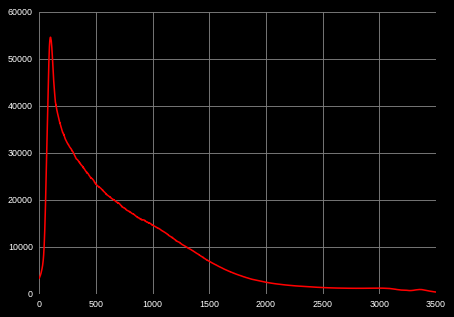

In [70]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
# Plot some data

# Set borders (spines)
ax.spines['bottom'].set_color('red')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

# Erase the grid
ax.grid(True, color='grey')

plt.plot(pixels, normalised_data, c ='red')


In [55]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
parameters = {
        "naverage": 1,
        "function": "spline1",
        "order": 2,
        "lreject": 3.0,
        "hreject": 3.0,
        "iter": 5
    }
function_options = ["spline1", "spline3", "chebyshev", "legendre"]

print("Please enter the values for the parameters you want (default values are shown):")
while True:
    for param, default in parameters.items():
        print(f"{param} (default: {default})")
    param = input("Enter the parameter you want to input (or 'done' to finish): ")
    if param.lower() == 'done':
        break
    if param in parameters:
        value = input(f"{param} (default: {parameters[param]}): ")
        if param == 'function':
            # Check if the input is one of the four options
            if value in function_options:
                parameters[param] = value
            else:
                print("Invalid input. 'function' parameter should be one of the following: " + ", ".join(function_options))
        else:
            # Check if the input can be converted to a number
            try:
                value = float(value)
                parameters[param] = value
            except ValueError:
                print("Invalid input. This parameter should be a number.")
    else:
        print("Invalid parameter. Please try again.")


Please enter the values for the parameters you want (default values are shown):
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid input. 'function' parameter should be one of the following: spline1, spline3, chebyshev, legendre
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid input. 'function' parameter should be one of the following: spline1, spline3, chebyshev, legendre
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid parameter. Please try again.
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (default: 3.0)
iter (default: 5)
Invalid parameter. Please try again.
naverage (default: 1)
function (default: spline1)
order (default: 2)
lreject (default: 3.0)
hreject (d

In [4]:
parameters

{'naverage': 1,
 'function': 'spline1',
 'order': 2,
 'lreject': 3.0,
 'hreject': 3.0,
 'iter': 5}

In [6]:
naverage = parameters['naverage']
naverage

1